In [1]:
import pandas
import seaborn
import time
import torch
from collections import defaultdict
from draugr.torch_utilities import global_torch_device
from matplotlib import pyplot
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.nn.functional import one_hot
from warg import NOD

from neodroidvision import PROJECT_APP_PATH
from neodroidvision.regression.vae.architectures.conditional_vae import ConditionalVAE
from objectives import loss_fn


In [2]:


fig_root = PROJECT_APP_PATH.user_data / "cvae"

config = NOD()
config.seed = 58329583
config.epochs = 1000
config.batch_size = 256
config.learning_rate = 0.001
config.encoder_layer_sizes = [784, 256]
config.decoder_layer_sizes = [256, 784]
config.latent_size = 10
config.print_every = 100
GLOBAL_DEVICE = global_torch_device()
timestamp = time.time()
torch.manual_seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(config.seed)

vae = ConditionalVAE(
    encoder_layer_sizes=config.encoder_layer_sizes,
    latent_size=config.latent_size,
    decoder_layer_sizes=config.decoder_layer_sizes,
    num_conditions=10,
).to(global_torch_device())
dataset = MNIST(
    root=str(PROJECT_APP_PATH.user_data / "MNIST"),
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)
tmsp_path = fig_root / str(timestamp)
if not tmsp_path.exists():
    tmsp_path.mkdir(parents=True)

if True:
    _list_of_files = list(fig_root.rglob("*.pth"))
    latest_model_path = str(max(_list_of_files, key=os.path.getctime))
    print(f"loading previous model: {latest_model_path}")
    if latest_model_path is not None:
        vae.load_state_dict(torch.load(latest_model_path))



loading previous model: /home/heider/.local/share/neodroidvision/cvae/model_state_dict39.pth


<Figure size 432x288 with 0 Axes>

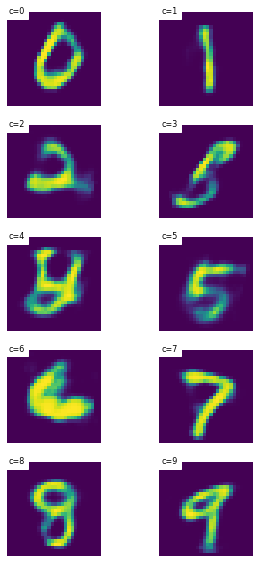

In [7]:

def main():
    """ """
    data_loader = DataLoader(
        dataset=dataset, batch_size=config.batch_size, shuffle=True
    )

    logs = defaultdict(list)



    for iteration, (original, label) in enumerate(data_loader):
        
        '''
        original, label = (
            original.to(global_torch_device()),
            label.to(global_torch_device()),
        )
        reconstruction, mean, log_var, z = vae(
            original, one_hot(label, 10).to(GLOBAL_DEVICE)
        )

        loss = loss_fn(reconstruction, original, mean, log_var)
'''

        condition_vector = (
            torch.arange(0, 10, device=GLOBAL_DEVICE).long()
        )
        sample = vae.sample(
            one_hot(condition_vector, 10).to(GLOBAL_DEVICE),
            num=condition_vector.size(0),
        )

        pyplot.figure()
        pyplot.figure(figsize=(5, 10))
        for p in range(10):
            pyplot.subplot(5, 2, p + 1)

            pyplot.text(
                0,
                0,
                f"c={condition_vector[p].item():d}",
                color="black",
                backgroundcolor="white",
                fontsize=8,
            )
            pyplot.imshow(sample[p].cpu().data.numpy())
            pyplot.axis("off")

        pyplot.show()
        break 




<Figure size 432x288 with 0 Axes>

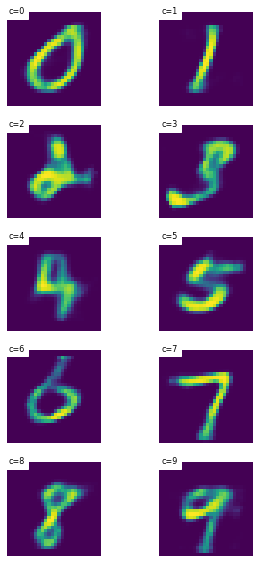

In [10]:
if __name__ == "__main__":
    main()